# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [0]:
!pip3 install torch torchvision
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [0]:
!mv ../visualization.py ../models.py ../train.py ../visualize.py ./
#!mv ./visualize.py ./visualize1.py

In [0]:
from collections import namedtuple, OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms, models

from itertools import product
from tqdm.auto import tqdm

from visualization1 import display_history
from models2 import *
from train import *
from visualize3 import *

device = torch.device("cuda:0")

# Загружаем данные

In [0]:
def normalize_data(transform, train, test):
    assert train or test, "train or test must be True"
    if train:
        data_train = dset.SVHN('./', transform=transform)
    if test:
        data_test = dset.SVHN('./', split='test', transform=transform)

    norm_info = {'mean': {'train': {1:0, 2:0, 3:0}, 'test': {1:0, 2:0, 3:0}}, 
                 'std': {'train': {1:0, 2:0, 3:0}, 'test': {1:0, 2:0, 3:0}}}
    for i in range(3):
        if train:
            norm_info['mean']['train'][i + 1] = (data_train.data / 255)[:, i, :, :].mean()
            norm_info['std']['train'][i + 1] = (data_train.data / 255)[:, i, :, :].std()
        if test:
            norm_info['mean']['test'][i + 1] = (data_test.data / 255)[:, i, :, :].mean()
            norm_info['std']['test'][i + 1] = (data_test.data / 255)[:, i, :, :].std()
    if train:
        data_train = dset.SVHN('./', 
                           transform=transforms.Compose(
                               transform.transforms + \
                               [
                               transforms.Normalize(mean=list(norm_info['mean']['train'].values()),
                                                    std=list(norm_info['std']['train'].values()))
                               ]                           
                           )
                          )
    if test:
        data_test = dset.SVHN('./', split='test', transform=transforms.Compose(
                               transform.transforms + \
                               [
                               transforms.Normalize(mean=list(norm_info['mean']['test'].values()),
                                                    std=list(norm_info['std']['test'].values()))   
                               ]
                           ))
    if not train:
        return data_test
    elif not test:
        return data_train
    return data_train, data_test
  
def check_normalization(data):
    means = [0, 0, 0]
    size = data.data.shape[0] * data.data.shape[2] * data.data.shape[3]
    for c in range(data.data.shape[1]):
        for i in range(data.data.shape[0]):
            means[c] += data[i][0][c, :, :].numpy().flatten().sum()
    means = np.array(means) / size
    assert np.all(np.isclose(means, 0, atol=1e-5)), "Means are not close to 0"
    stds = [0, 0, 0]
    for c in range(data.data.shape[1]):
        for i in range(data.data.shape[0]):
            stds[c] += (data[i][0][c, :, :].numpy().flatten()**2).sum()
    stds = np.sqrt(np.array(stds)/size)
    assert np.all(np.isclose(stds, 1, atol=1e-5)), "Stds are not close to 1"
    
    
  
def create_subsamples(train_percent, val_percent):
    train_indices_ = train_indices[:int(len(train_indices) * train_percent)]
    train_sampler = SubsetRandomSampler(train_indices_)
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)

    val_indices_ = val_indices[:int(len(val_indices) * val_percent)]
    val_sampler = SubsetRandomSampler(val_indices_)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=val_sampler)
    return train_loader, val_loader

In [0]:
check_normalization(data_train)

In [0]:
data_train, data_test = normalize_data(transforms.Compose([
                                       transforms.ToTensor()
                                      ]), True, True)
data_train_images = dset.SVHN('./data/', split='train', download=True) #for visualization

Using downloaded and verified file: ./data/train_32x32.mat


In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [0]:
reg_model = Regular(device)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

In [0]:
optimizer = optim.SGD(reg_model.parameters(), lr=1e-1, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(reg_model, device, train_loader, val_loader, loss, optimizer, 1)

Epoch: 1, Average loss: 1.414357, Train accuracy: 0.525919, Val accuracy: 0.731895


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

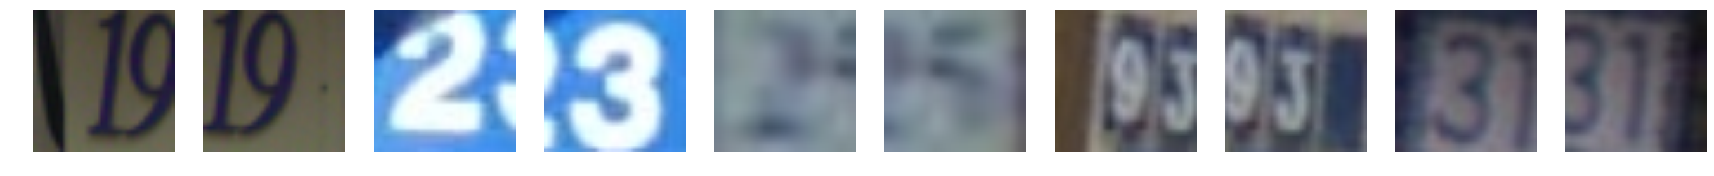

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.Resize(224)
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [0]:
data_train, data_test = normalize_data(
    transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),                           
    ]), True, True)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [0]:
lenet_model = LeNet(device)
optimizer = optim.Adam(lenet_model.parameters(), lr=1e-2, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(lenet_model, device, train_loader, val_loader, loss, optimizer, 5)

# MyModel

In [0]:
my_model = MyModel(device)
optimizer = optim.Adam(my_model.parameters(), lr=1e-2, weight_decay=1e-4)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: .7**(epoch))
loss_history, train_history, val_history = train_model(my_model, device, train_loader, val_loader, loss, optimizer, 20, scheduler)

# ResNet

In [0]:
def scheduler(lr_lambda, optimizer):
    func = lambda epoch: (epoch+1) / 3 if epoch <= 2 else (7-epoch+3) / 8
    return optim.lr_scheduler.LambdaLR(optimizer, func)

In [0]:
resnet_model = ResNet(device)
train_loader_, val_loader_ = create_subsamples(1., 1.)#.125 for parameters tuning
lr = 8 * 1e-3
_ro = .125
alpha = 1e-2 / 8
optimizer = optim.SGD(resnet_model.parameters(), lr=lr, momentum=1-_ro, nesterov=True, weight_decay=alpha)
scheduler = scheduler(lr, optimizer)
loss_history, train_history, val_history = train_model(resnet_model, device, train_loader_, val_loader_, loss, optimizer, 10, scheduler)

Epoch: 1, Average loss: 0.025904, Train accuracy: 0.995768, Val accuracy: 0.958842


Epoch: 2, Average loss: 0.016894, Train accuracy: 0.997935, Val accuracy: 0.957887


Epoch: 3, Average loss: 0.011272, Train accuracy: 0.999215, Val accuracy: 0.955498


Epoch: 4, Average loss: 0.007412, Train accuracy: 0.999761, Val accuracy: 0.958501


Epoch: 5, Average loss: 0.006027, Train accuracy: 0.999881, Val accuracy: 0.958774


Epoch: 6, Average loss: 0.005486, Train accuracy: 0.999949, Val accuracy: 0.960207


Epoch: 7, Average loss: 0.005064, Train accuracy: 0.999932, Val accuracy: 0.960754


Epoch: 8, Average loss: 0.005002, Train accuracy: 0.999966, Val accuracy: 0.960549


Epoch: 9, Average loss: 0.004859, Train accuracy: 0.999949, Val accuracy: 0.960549


Epoch: 10, Average loss: 0.004797, Train accuracy: 0.999966, Val accuracy: 0.960685


## Visualize

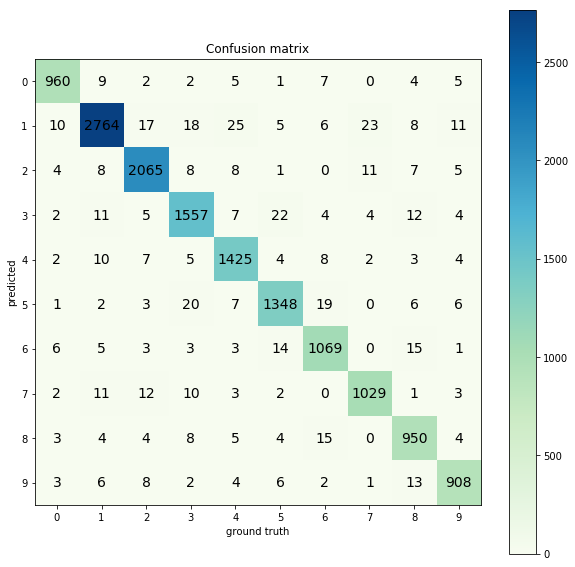

In [0]:
predictions, gt = evaluate_model(resnet_model, device, batch_size, data_train, val_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix, plt)

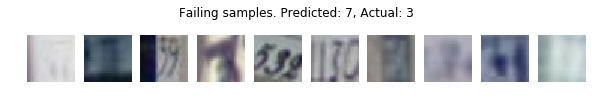

In [0]:
visualize_predicted_actual(7, 3, predictions, gt, np.array(val_indices), data_train_images, plt)

# Подбор гиперпараметров

In [0]:
def create_random_grid(dict, iterations):
    params_total_number = np.prod([len(param) for param in dict.values()])
    choises = np.random.choice(params_total_number, iterations, False)
    run_record = []
    for ind, val in enumerate(product(*dict.values())):
        if(ind in choises):
            run_record.append([Hyperparams(*val), None])
    np.random.shuffle(run_record)
    return OrderedDict(run_record)

In [0]:
batch_size = 64
epoch_num = 20
grid = {'learning_rate': [.0166] 
        'anneal_coeff': [.5],
        'anneal_epochs': [1],
        'reg': [.015],
        'minus_momentum': [.25]
        }
Hyperparams = namedtuple("Hyperparams", grid.keys())
RunResult = namedtuple("RunResult", ['train_history', 'val_history', 'final_val_accuracy'])
    
iterations = 1
run_record = create_random_grid(grid, iterations)

train_loader_, val_loader = create_subsamples(.25, 1.)

for ind, params in enumerate(run_record.keys()):
    print("Iteration: " + str(ind+1) + ", " + str(params))
    lenet_model = MyModel()
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: params.anneal_coeff**(epoch // params.anneal_epochs))
    optimizer = optim.SGD(lenet_model.parameters(), lr=params.learning_rate, weight_decay=params.reg, 
                          momentum=1-params.minus_momentum, nesterov=True)
    loss_history, train_history, val_history = \
        train_model(lenet_model, train_loader_, val_loader_, loss, optimizer, epoch_num, scheduler)
    run_record[params] = RunResult(train_history, val_history, val_history[-1])
    print('\n')

In [0]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.83, best hyperparams: Hyperparams(learning_rate=0.0332, anneal_coeff=0.8, anneal_epochs=1, reg=0.015, minus_momentum=0.25)


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [0]:
# TODO Write the code to compute accuracy on test set
#Final test accuracy -  0.9415719114935464 - MyModel
#Final test accuracy -  0.9650814382298709 -ResNet
final_test_accuracy = 0.0
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(resnet_model, device, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9650814382298709
